In [34]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
from datetime import datetime
import joblib
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
df = pd.read_csv("data4_population_updated.csv")


crime_weights = {"F": 4, "D": 2, "V": 1}
df["crime_weight"] = df["LAW_CAT_CD"].map(crime_weights)
crime_data = df.groupby("NTAName").agg({
    "crime_weight": "sum",       
    "Population": "first"   
}).reset_index()

unique_values = df['NTAName'].nunique()

print(f"Unique NTAName values: {unique_values}")

Unique NTAName values: 252


In [36]:
crime_weight_map = {
    # Highest Severity (Violent / Life Threatening)
    'MURDER & NON-NEGL. MANSLAUGHTE': 10, 'RAPE': 10, 'FELONY ASSAULT': 10, 'SEX CRIMES': 10, 
    'KIDNAPPING & RELATED OFFENSES': 10, 'ARSON': 10, 'HOMICIDE-NEGLIGENT,UNCLASSIFIE': 10, 'HOMICIDE-NEGLIGENT-VEHICLE': 10,
    
    # Very Dangerous
    'ROBBERY': 9, 'BURGLARY': 9, 'GRAND LARCENY OF MOTOR VEHICLE': 9,
    
    # Dangerous Weapons & Assault
    'DANGEROUS WEAPONS': 8, 'DANGEROUS DRUGS': 8, 'ASSAULT 3 & RELATED OFFENSES': 8, 'ESCAPE 3': 8,
    
    # High Impact Theft
    'GRAND LARCENY': 7, 'CRIMINAL MISCHIEF & RELATED OF': 7, 'CRIMINAL TRESPASS': 7, 'POSSESSION OF STOLEN PROPERTY': 7,
    
    # Fraud & Forgery Crimes
    'FRAUDS': 6, 'OFFENSES INVOLVING FRAUD': 6, 'FORGERY': 6, 'THEFT-FRAUD': 6,
    
    # Common Crimes
    'PETIT LARCENY': 5, 'OTHER OFFENSES RELATED TO THEFT': 5, 'DISORDERLY CONDUCT': 5,
    
    # Quality of Life Crimes
    'PROSTITUTION & RELATED OFFENSES': 4, 'GAMBLING': 4, 'INTOXICATED & IMPAIRED DRIVING': 4, 'INTOXICATED/IMPAIRED DRIVING': 4,
    
    # Traffic / Minor Drugs / Alcohol
    'VEHICLE AND TRAFFIC LAWS': 3, 'ALCOHOLIC BEVERAGE CONTROL LAW': 3, 'OTHER STATE LAWS': 3, 'OTHER STATE LAWS (NON PENAL LAW)': 3,
    
    # Very Minor Crimes
    'HARRASSMENT 2': 2, 'JOSTLING': 2, 'LOITERING': 2, 'LOITERING/GAMBLING (CARDS, DIC': 2, 
    
    # Admin / Health / Parking / Noise
    'ADMINISTRATIVE CODE': 1, 'ADMINISTRATIVE CODES': 1, 'MOVING INFRACTIONS': 1, 'PARKING OFFENSES': 1, 
    'FOR OTHER AUTHORITIES': 1, 'NEW YORK CITY HEALTH CODE': 1, 'FORTUNE TELLING': 1, 'DISRUPTION OF A RELIGIOUS SERV': 1,
    '(null)': 1, 'OFFENSES AGAINST PUBLIC ADMINI': 1, 'OFFENSES AGAINST PUBLIC SAFETY': 1, 
    'OFFENSES AGAINST THE PERSON': 1, 'OFF. AGNST PUB ORD SENSBLTY &': 1, 'ANTICIPATORY OFFENSES': 1, 
    'CHILD ABANDONMENT/NON SUPPORT 1': 1, 'OFFENSES RELATED TO CHILDREN': 1, 'BURGLAR\'S TOOLS': 1, 
    'CANNABIS RELATED OFFENSES': 1
}
df['crime_weight'] = df['OFNS_DESC'].map(crime_weight_map).fillna(1)

In [37]:
import pandas as pd
import numpy as np

# Convert ARREST_DATE column to datetime and use a Pandas timestamp for current date
df['Date'] = pd.to_datetime(df['ARREST_DATE'])
current_date = pd.Timestamp.now()

# Calculate the number of days since the crime occurred
df['days_since_crime'] = (current_date - df['Date']).dt.days

# Apply the decay factor to the crime_weight using NumPy's np.power for potential performance gain
decay_factor = 0.99  # Adjust this value as needed
df['adjusted_crime_weight'] = df['crime_weight'] * np.power(decay_factor, df['days_since_crime'])

# Alternative decay calculation using half-life (uncomment to use)
# half_life = 365.0  # Example: 1 year half-life
# df['adjusted_crime_weight'] = df['crime_weight'] * np.exp(-np.log(2) * df['days_since_crime'] / half_life)

# Group data by NTAName, aggregating the sum of adjusted crime weight and grabbing the first Population value
crime_data = df.groupby("NTAName").agg({
    "adjusted_crime_weight": "sum",
    "Population": "first"
}).reset_index()

# Drop rows with missing or non-positive population values to avoid division errors
crime_data = crime_data.dropna(subset=["Population"])
crime_data = crime_data[crime_data["Population"] > 0]

# Compute weighted crime rate per 10,000 residents
crime_data["weighted_crime_rate"] = (crime_data["adjusted_crime_weight"] / crime_data["Population"]) * 1000

# Normalize the weighted crime rate to a 0-1 scale with a safeguard against division by zero
min_rate = crime_data["weighted_crime_rate"].min()
max_rate = crime_data["weighted_crime_rate"].max()
if max_rate == min_rate:
    crime_data["normalized_weighted_rate"] = 0
else:
    crime_data["normalized_weighted_rate"] = (crime_data["weighted_crime_rate"] - min_rate) / (max_rate - min_rate)

# Calculate the safety index as an inverse of the normalized crime rate (scaled to 0-100)
crime_data["safety_index"] = (1 - crime_data["normalized_weighted_rate"]) * 100

# Display the key columns for review
print(crime_data[["NTAName", "weighted_crime_rate", "safety_index"]])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(crime_data[["NTAName", "weighted_crime_rate", "safety_index"]]) 

                                                      NTAName  \
0                                                    Allerton   
4                                             Astoria Central   
5                                 Astoria East-Woodside North   
6                              Astoria North-Ditmars-Steinway   
7                                                Astoria Park   
8                                                  Auburndale   
9                                                Baisley Park   
11                                                 Bath Beach   
12                                                  Bay Ridge   
13                                      Bay Terrace-Clearview   
15                                               Bedford Park   
17                                    Bedford-Stuyvesant West   
18                                                  Bellerose   
19                                                    Belmont   
21                       

In [38]:
print(crime_data)

                                                      NTAName  \
0                                                    Allerton   
4                                             Astoria Central   
5                                 Astoria East-Woodside North   
6                              Astoria North-Ditmars-Steinway   
7                                                Astoria Park   
8                                                  Auburndale   
9                                                Baisley Park   
11                                                 Bath Beach   
12                                                  Bay Ridge   
13                                      Bay Terrace-Clearview   
15                                               Bedford Park   
17                                    Bedford-Stuyvesant West   
18                                                  Bellerose   
19                                                    Belmont   
21                       

In [39]:
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None)  


print(crime_data)

                                                      NTAName  \
0                                                    Allerton   
4                                             Astoria Central   
5                                 Astoria East-Woodside North   
6                              Astoria North-Ditmars-Steinway   
7                                                Astoria Park   
8                                                  Auburndale   
9                                                Baisley Park   
11                                                 Bath Beach   
12                                                  Bay Ridge   
13                                      Bay Terrace-Clearview   
15                                               Bedford Park   
17                                    Bedford-Stuyvesant West   
18                                                  Bellerose   
19                                                    Belmont   
21                       

In [40]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c  # Distance in kilometers

In [41]:
print(crime_data[["NTAName", "weighted_crime_rate", "safety_index"]])

                                                      NTAName  \
0                                                    Allerton   
4                                             Astoria Central   
5                                 Astoria East-Woodside North   
6                              Astoria North-Ditmars-Steinway   
7                                                Astoria Park   
8                                                  Auburndale   
9                                                Baisley Park   
11                                                 Bath Beach   
12                                                  Bay Ridge   
13                                      Bay Terrace-Clearview   
15                                               Bedford Park   
17                                    Bedford-Stuyvesant West   
18                                                  Bellerose   
19                                                    Belmont   
21                       

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


X = crime_data.drop(columns=["safety_index", "NTAName"])  
y = crime_data["safety_index"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(
    random_state=42, 
    n_estimators=100,  
    
    max_depth=10,      
    
    min_samples_split=5,  
    
    min_samples_leaf=2    
    
)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [43]:
def predict_safety(lat, lon, model, radius=0.4):

    df["distance"] = df.apply(lambda row: haversine(lat, lon, row["Latitude"], row["Longitude"]), axis=1)
    crimes_in_radius = df[df["distance"] <= radius]


    if crimes_in_radius.empty:
        return "Safe (No crimes found)"

   
    crime_weight = crimes_in_radius["crime_weight"].sum()
    population = crimes_in_radius["Population"].mean()

 
    weighted_crime_rate = (crime_weight / population) * 100000 if population > 0 else 0

   
    features = pd.DataFrame({
        "crime_weight": [crime_weight],
        "Population": [population],
        "weighted_crime_rate": [weighted_crime_rate],
        "normalized_weighted_rate": [(weighted_crime_rate - X_train["weighted_crime_rate"].min()) / 
                                     (X_train["weighted_crime_rate"].max() - X_train["weighted_crime_rate"].min())]
    })

    # Add missing columns (e.g., one-hot encoded neighborhoods) with default values
    for col in X_train.columns:
        if col not in features.columns:
            features[col] = 0  # Default to 0 for missing columns

    # Ensure the feature columns are in the same order as X_train
    features = features[X_train.columns]

    # Predict safety index
    safety_index = model.predict(features)[0]

    # Classify as safe or not safe based on a threshold
    threshold = 50  # Define your safety threshold
    if safety_index > threshold:
        return f"Safe (Safety Index: {safety_index:.2f})"
    else:
        return f"Not Safe (Safety Index: {safety_index:.2f})"

In [44]:
# Mid town manhattan
latitude = 40.743045157845984
longitude = -73.99617681464115


safety_status = predict_safety(latitude, longitude, model)
print(safety_status)

Not Safe (Safety Index: 33.05)


In [45]:

def get_top_crimes_in_area(lat, lon, radius=0.4, category_column='LAW_CAT_CD', crime_column='OFNS_DESC', top_n=3):
   
    df['distance'] = df.apply(lambda row: haversine(lat, lon, row['Latitude'], row['Longitude']), axis=1)
    

    crimes_in_radius = df[df['distance'] <= radius]
    

    crime_counts = crimes_in_radius.groupby([category_column, crime_column]).size().reset_index(name='count')
    
    crime_counts = crime_counts.sort_values(by=[category_column, 'count'], ascending=[True, False])
    
 
    top_crimes = crime_counts.groupby(category_column).head(top_n)
    
    return top_crimes



In [46]:

latitude = 40.75485647228779
longitude = -73.97384112322268
radius = 0.4  

top_crimes_in_area = get_top_crimes_in_area(latitude, longitude, radius)
print(top_crimes_in_area)

   LAW_CAT_CD                        OFNS_DESC  count
7           F                    GRAND LARCENY     79
4           F                   FELONY ASSAULT     43
14          F                          ROBBERY     36
33          M                    PETIT LARCENY     93
16          M     ASSAULT 3 & RELATED OFFENSES     74
30          M  OTHER OFFENSES RELATED TO THEFT     31
38          V                 OTHER STATE LAWS      3
37          V          MISCELLANEOUS PENAL LAW      1


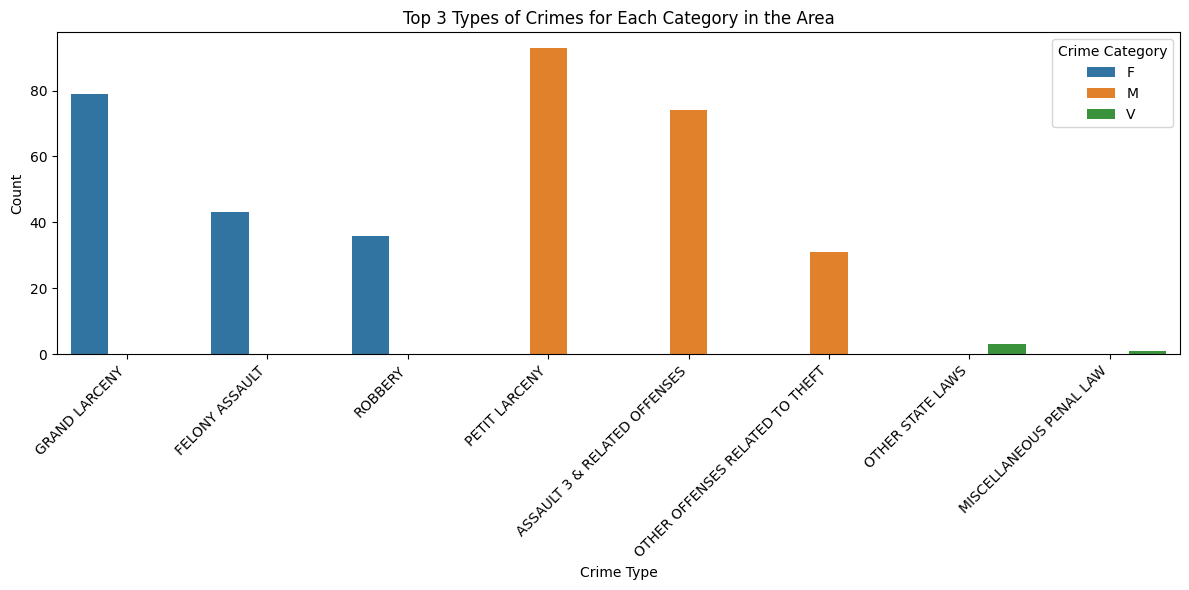

In [47]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_crimes_in_area,
    x='OFNS_DESC',
    y='count',
    hue='LAW_CAT_CD',
    dodge=True
)
plt.title('Top 3 Types of Crimes for Each Category in the Area')
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Crime Category')
plt.tight_layout()
plt.show()

In [48]:
# To save model
import joblib
import pickle
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [49]:
# To load the model

# Using joblib
loaded_model = joblib.load('random_forest_model.pkl')

# Using pickle
with open('random_forest_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [50]:
import folium


latitude = 40.75485647228779
longitude = -73.97384112322268


radius_meters = 0.4 * 1609.34  


map_ny = folium.Map(location=[latitude, longitude], zoom_start=14)


folium.Circle(
    location=[latitude, longitude],
    radius=radius_meters,
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.2
).add_to(map_ny)


map_ny
